In [1]:
from transformer_reasoning.utils import get_project_root
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_from_disk
from transformer_reasoning.train.train_llama import InfiniteBiosDataset
import torch

N = 10000
num_parameters = 1_000_000
order = 1
wd= 0.01

parent_dir = get_project_root() / f"results/n{N}_p{num_parameters}_o{order}_wd{wd}_infinite"
checkpoints = [d for d in parent_dir.glob("checkpoint-*") if d.is_dir()]

# Sort by checkpoint number and get the latest
latest = max(checkpoints, key=lambda x: int(x.name.split("-")[1]))
model_path = latest
model = AutoModelForCausalLM.from_pretrained(model_path).cuda()
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-160m")

In [2]:
profiles = load_from_disk(str(get_project_root() / f"generated_data/profiles_dataset_{N}"))

shuffled_indices = torch.randperm(len(profiles)).tolist()
heldout_indices = shuffled_indices[:1000]
retained_indices = shuffled_indices[1000:]

train_dataset = InfiniteBiosDataset(
    profiles_dataset=profiles,
    tokenizer=tokenizer,
    max_seq_len=512,
    max_order=2,
    qa_prob=0.5,
    qa_indices=retained_indices
)

td = iter(train_dataset)

qa_dataset = load_from_disk(str(get_project_root() / f"generated_data/qa_dataset_{N}"))

In [3]:

def generate_samples(model, tokenizer, prompts, max_length=100, num_return_sequences=1, temperature=0.7, top_p=0.9):
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, padding_side="left").to(model.device)
    
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    
    # Decode and clean up the generated sequences
    generated_texts = []
    for sequence in outputs:
        text = tokenizer.decode(sequence, skip_special_tokens=True)
        generated_texts.append(text)
    
    return generated_texts

tokenizer.pad_token = tokenizer.eos_token

profiles_dataset = load_from_disk("generated_data/profiles_dataset_25000")
# Example usage:
prompts = [
    "Question: What was Alice's birth date? Answer:",
    "Question: What was Bob's university? Answer:",
    "Question: What was Bob's parent's employer? Answer:",
    "",
    "Bob",
    "Question: What was Bob's parent's employer? Answer:",
    "Question: What was Bob's best friend's university? Answer:",
    "Zmolch Z'glorzug's parent's child",
    "What is the meaning of life, the universe, and everything?",
]

qa_prompts = []
for profile in profiles_dataset.select(range(10)):
    qa_prompts.extend([
        f"Question: What was {profile['name']}'s employer? Answer:",
        f"Question: What was {profile['name']}'s best friend's university? Answer:",
        f"Question: What was {profile['name']}'s worst enemy's employer? Answer:",
        f"Question: What was {profile['name']}'s worst enemy's worst enemy? Answer:",
        f"Question: What was {profile['name']}'s best friend's best friend? Answer:",
    ])

num_return_sequences = 10

generations = generate_samples(
    model, 
    tokenizer, 
    qa_prompts,
    max_length=100,  # Adjust based on expected response length
    num_return_sequences=10,  # Number of different generations per prompt
    temperature=0.7,  # Higher = more random, lower = more deterministic
    top_p=0.9,  # Nucleus sampling parameter
)



for i, prompt in enumerate(qa_prompts):
    print(f"\nPrompt: {prompt}")
    print(f"Name: {profiles_dataset[i//5]['name']},\n\
          best friend: {profiles_dataset[i//5]['best_friend']['name']},\n\
          worst enemy: {profiles_dataset[i//5]['worst_enemy']['name']},\n\
          best friend's university: {profiles_dataset[profiles_dataset[i//3]['best_friend']['index']]['university']},\n\
          university: {profiles_dataset[i//5]['university']},\n\
          worst enemy's employer: {profiles_dataset[profiles_dataset[i//3]['worst_enemy']['index']]['employer']},\n\
          employer: {profiles_dataset[i//5]['employer']}")
    for j in range(num_return_sequences):
        print(f"Generation {j+1}: {generations[i*num_return_sequences + j]}")

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



Prompt: Question: What was Katerine Asha Augustson's employer? Answer:
Name: Katerine Asha Augustson,
          best friend: Lajuana Roxie Spiegelman,
          worst enemy: Gaye Mercy Liebenthal,
          best friend's university: Sun Yat-Sen University,
          university: Zhejiang University,
          worst enemy's employer: Polygon Bikes,
          employer: Indofood
Generation 1: Question: What was Katerine Asha Augustson's employer? Answer: Kimia Far08-28. Chongqun Hac08- is the date of the subject. -Yass, Victoria is where they first is is where they popped out. Cherlyn Nic Hogberg was the thhisbery, parent. Beckie Nancve was the principal adversary of the subject. Nicki Mon Nickleyongmrer is their go. Lion is
Generation 2: Question: What was Katerine Asha Augustson's employer? Answer: Kimia Far08-28. - key subject's is the Kere Ceman is their go T subject. proud person was Emory Jrum Malt is the subject's most Y2070e is the subject's most was the subject's most has for, th

In [5]:
next(td)

{'input_ids': [0,
  44,
  23242,
  284,
  1997,
  3163,
  571,
  5901,
  310,
  835,
  1503,
  8440,
  3599,
  324,
  571,
  6995,
  19773,
  5841,
  1728,
  13,
  285,
  597,
  1472,
  3965,
  9979,
  273,
  352,
  15,
  775,
  284,
  11290,
  90,
  19953,
  48493,
  2083,
  900,
  1160,
  686,
  358,
  247,
  9979,
  2885,
  15,
  6304,
  8807,
  6393,
  14906,
  36685,
  254,
  310,
  253,
  2256,
  434,
  36536,
  1461,
  301,
  386,
  15,
  1384,
  2504,
  14,
  2941,
  14,
  746,
  10880,
  253,
  3522,
  273,
  4201,
  15,
  8174,
  466,
  31903,
  66,
  8081,
  261,
  601,
  369,
  253,
  270,
  1351,
  273,
  616,
  6242,
  15,
  611,
  6481,
  3230,
  13,
  6359,
  6976,
  37553,
  686,
  358,
  15,
  30918,
  2499,
  273,
  4135,
  3805,
  15,
  0,
  36,
  7822,
  39107,
  2070,
  67,
  7292,
  13,
  5686,
  327,
  34283,
  14,
  883,
  14,
  1047,
  13,
  310,
  247,
  11906,
  4677,
  275,
  616,
  1673,
  15,
  11064,
  1063,
  36297,
  378,
  4843,
  19953,
  369,
  616,

In [2]:
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

from transformer_reasoning.train.train_utils import evaluate_single_model
from transformer_reasoning.train.dataset import InfiniteQADataset, load_and_prepare_datasets
from transformers import LlamaForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
import torch

# Load model and tokenizer
model_path = "/mnt/ssd-1/david/transformer-reasoning/results/n10000_p5128560_omin1_omax2_wd0.1_l4_lr0.001_beta10.99_sf_r17/checkpoint-46415"
model = LlamaForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/llama_multihop_tokenizer")
tokenizer.pad_token = tokenizer.eos_token
model.cuda()

optimizer_state = torch.load(f"{model_path}/optimizer.pt")
heldout_sets = optimizer_state['heldout_sets']

# Create datasets
train_dataset = load_and_prepare_datasets(
    tokenizer,
    N=10000,
    orders=[1,2],
    relations="17",
    hop_ratio=0.1,
    heldout_sets=heldout_sets
)

eval_dataset = InfiniteQADataset(
    profiles_dataset=train_dataset.profiles,
    tokenizer=tokenizer,
    max_seq_len=512,
    orders=[2],
    mode="train",
    heldout_sets=train_dataset.heldout_sets
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4)
eval_loader = DataLoader(eval_dataset, batch_size=32, num_workers=4)

# Get single batches
train_batch = next(iter(train_loader))
eval_batch = next(iter(eval_loader))

# Training loss
model.eval()
train_batch = {k: v.cuda() if hasattr(v, 'to') else v for k, v in train_batch.items()}
train_outputs = model(**{k:v for k,v in train_batch.items() if k != 'text'})
train_loss = train_outputs.loss.item()

eval_batch = {k: v.cuda() if hasattr(v, 'to') else v for k, v in eval_batch.items()}
eval_outputs = model(**{k:v for k,v in eval_batch.items() if k != 'text'})
eval_loss = eval_outputs.loss.item()

print(f"Train loss: {train_loss}")
print(f"Eval loss: {eval_loss}")


eval_results = evaluate_single_model(model, eval_loader, 0, "train_twohop")
eval_full_loss = eval_results['loss']
train_results = evaluate_single_model(model, train_loader, 0, "train_twohop")
train_full_loss = train_results['loss']

print(f"Full train loss: {train_full_loss}")
print(f"Full eval loss: {eval_full_loss}")

Train loss: 1.1519644260406494
Eval loss: 1.255372166633606


Evaluating train_twohop:   0%|          | 1/3125 [00:03<3:18:52,  3.82s/it]


Step 0: train_twohop Loss = 8.209446222029605


Evaluating train_twohop:   0%|          | 1/3125 [00:03<2:59:12,  3.44s/it]

Step 0: train_twohop Loss = 7.6571067405623205
Full train loss: 7.6571067405623205
Full eval loss: 8.209446222029605


In [1]:
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

from transformer_reasoning.train.train_utils import evaluate_single_model
from transformer_reasoning.train.dataset import InfiniteQADataset, load_and_prepare_datasets
from transformers import LlamaForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
import torch

# Load model and tokenizer
model_path = "/mnt/ssd-1/david/transformer-reasoning/results/n10000_p5128560_omin1_omax2_wd0.1_l4_lr0.001_beta10.99_sf_r17/checkpoint-900000"
model = LlamaForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/llama_multihop_tokenizer")
tokenizer.pad_token = tokenizer.eos_token
model.cuda()

optimizer_state = torch.load(f"{model_path}/optimizer.pt")
heldout_sets = optimizer_state['heldout_sets']

# Create datasets
train_dataset = load_and_prepare_datasets(
    tokenizer,
    N=10000,
    orders=[1,2],
    relations="17",
    hop_ratio=0.1,
    heldout_sets=heldout_sets
)

eval_dataset = InfiniteQADataset(
    profiles_dataset=train_dataset.profiles,
    tokenizer=tokenizer,
    max_seq_len=512,
    orders=[2],
    mode="train",
    heldout_sets=train_dataset.heldout_sets
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4)
eval_loader = DataLoader(eval_dataset, batch_size=32, num_workers=4)

# Get single batches
train_batch = next(iter(train_loader))
eval_batch = next(iter(eval_loader))

# Training loss
model.eval()
train_batch = {k: v.cuda() if hasattr(v, 'to') else v for k, v in train_batch.items()}
train_outputs = model(**{k:v for k,v in train_batch.items() if k != 'text'})
train_loss = train_outputs.loss.item()

eval_batch = {k: v.cuda() if hasattr(v, 'to') else v for k, v in eval_batch.items()}
eval_outputs = model(**{k:v for k,v in eval_batch.items() if k != 'text'})
eval_loss = eval_outputs.loss.item()

print(f"Train loss: {train_loss}")
print(f"Eval loss: {eval_loss}")


eval_results = evaluate_single_model(model, eval_loader, 0, "train_twohop")
eval_full_loss = eval_results['loss']
train_results = evaluate_single_model(model, train_loader, 0, "train_twohop")
train_full_loss = train_results['loss']

print(f"Full train loss: {train_full_loss}")
print(f"Full eval loss: {eval_full_loss}")


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train loss: 0.6554131507873535
Eval loss: 1.5992106199264526


Evaluating train_twohop:   0%|          | 1/3125 [00:03<3:14:31,  3.74s/it]


Step 0: train_twohop Loss = 10.307321354351213


Evaluating train_twohop:   0%|          | 1/3125 [00:03<3:10:38,  3.66s/it]

Step 0: train_twohop Loss = 4.363760017391791
Full train loss: 4.363760017391791
Full eval loss: 10.307321354351213


In [10]:
train_batch['text'][0]

"Question: What was Myles Lilli Waldoch's blackmailer's birth city? Answer: Ingham, Queensland<|endoftext|>Question: What was Tyson Linh Croley's betrayer's hero? Answer: Vikki Millie Holts<|endoftext|>Question: What was Hermelinda Sally Mitschelen's protege's parent? Answer: Olene Suzanne Beish<|endoftext|>Question: What was Carlita Letty Ahner's business partner's blackmailer? Answer: Reuben Kristin Kamrowski<|endoftext|>Question: What was Alfred Hannah Vogus's protege's employer? Answer: Kereta Api Indonesia<|endoftext|>Question: What was Keitha Shaniqua Deshotel's mentor's betrayer? Answer: Maryanna Valentin Pottenger<|endoftext|>Question: What was Theressa Vada Kitty's evil twin's mentor? Answer: Shae Lucilla Risius<|endoftext|>Question: What was Aundrea Lia Boulay's parent's university? Answer: Central South University<|endoftext|>Question: What was Sandi Jim Eichenlaub's parent's evil twin? Answer: Hang Carlyn Jaquet<|endoftext|>Question: What was Dyan Pat Anselm's mentor's wors

In [11]:
eval_batch['text'][0]

"Question: What was Myles Lilli Waldoch's blackmailer's birth city? Answer: Ingham, Queensland<|endoftext|>Question: What was Tyson Linh Croley's betrayer's hero? Answer: Vikki Millie Holts<|endoftext|>Question: What was Hermelinda Sally Mitschelen's protege's parent? Answer: Olene Suzanne Beish<|endoftext|>Question: What was Carlita Letty Ahner's business partner's blackmailer? Answer: Reuben Kristin Kamrowski<|endoftext|>Question: What was Alfred Hannah Vogus's protege's employer? Answer: Kereta Api Indonesia<|endoftext|>Question: What was Keitha Shaniqua Deshotel's mentor's betrayer? Answer: Maryanna Valentin Pottenger<|endoftext|>Question: What was Theressa Vada Kitty's evil twin's mentor? Answer: Shae Lucilla Risius<|endoftext|>Question: What was Aundrea Lia Boulay's parent's university? Answer: Central South University<|endoftext|>Question: What was Sandi Jim Eichenlaub's parent's evil twin? Answer: Hang Carlyn Jaquet<|endoftext|>Question: What was Dyan Pat Anselm's mentor's wors

In [12]:
for i, c in enumerate(train_batch['text'][0]):
    if c != eval_batch['text'][0][i]:
        print(i)
        break


1948


In [16]:
eval_batch['text'][0][1900:]

"ftext|>Question: What was Cassidy Loree Holes's spouse's parent? Answer: Felicidad Meri Luman<|endoftext|>Question: What was Catherine Maryetta Craun's debtor's debtor? Answer: Sheryl Lavera Bocook<|endoftext|>Question: What was Cori Dylan Lowin's grandchild's best friend? Answer: Lakia Bettie Durrwachter<|endoftext|>Question: What was Despina Allena Barbian's blackmailer's hero? Answer: Alene Chieko Terada<|endoftext|>Question: What was Barabara Shawanda Emily's betrayer's university? Answer: Nanjing University<|endoftext|>Question: What was Myong Madalene Houseworth's evil twin's hero? Answer: Khalilah Eliseo Deyarmond<|endoftext|>Question: What was Allena Hyman Karman's grandchild's birth date? Answer: 2033-08-08<|endoftext|>Question: What was Julee Rebeca Boillot's grandchild's grandchild? Answer: Prudence Princess Arora<|endoftext|>Question: What was Ardell Delilah Sathiraboot's child's employer? Answer: Bank Mandiri<|endoftext|>Question: What was Joann Sheryl Rosboril's grandchi

In [17]:
train_batch['text'][0][1900:]

"ftext|>Question: What was Cassidy Loree Holes's parent? Answer: Alton Lita Werst<|endoftext|>Question: What was Henrietta Carissa Ruzicki's business partner's debtor? Answer: Yelena Waylon Acedo<|endoftext|>Question: What was Ferne Leone Vainio's blackmailer's hero? Answer: Marceline Georgeanna Valderamo<|endoftext|>Question: What was Barabara Shawanda Emily's betrayer's university? Answer: Nanjing University<|endoftext|>Question: What was Myong Madalene Houseworth's evil twin's hero? Answer: Khalilah Eliseo Deyarmond<|endoftext|>Question: What was Allena Hyman Karman's grandchild's birth date? Answer: 2033-08-08<|endoftext|>Question: What was Julee Rebeca Boillot's grandchild's grandchild? Answer: Prudence Princess Arora<|endoftext|>Question: What was Ardell Delilah Sathiraboot's child's employer? Answer: Bank Mandiri<|endoftext|>Question: What was Joann Sheryl Rosboril's grandchild's birth city? Answer: Iron Knob, South Australia<|endoftext|>Question: What was Mose Isabell Grella's 

In [5]:
from datasets import load_dataset
from collections import Counter

# Load both datasets
profiles1 = load_dataset("EleutherAI/profiles_dataset_15000_uniform_r17")["train"]
profiles2 = load_dataset("EleutherAI/profiles_dataset_250000_uniform_r17")["train"]

# Extract names from both datasets
names1 = set(profiles1["name"])
names2 = set(profiles2["name"])
print('names setted')
# Find collisions
collisions = names1.intersection(names2)

print(f"Found {len(collisions)} name collisions between datasets")
print("\nExample collisions:")
for name in list(collisions)[:10]:
    print(f"\n{name}:")
    print("Dataset 1:", profiles1[profiles1["name"] == name][0])
    print("Dataset 2:", profiles2[profiles2["name"] == name][0])

names setted
Found 0 name collisions between datasets

Example collisions:


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


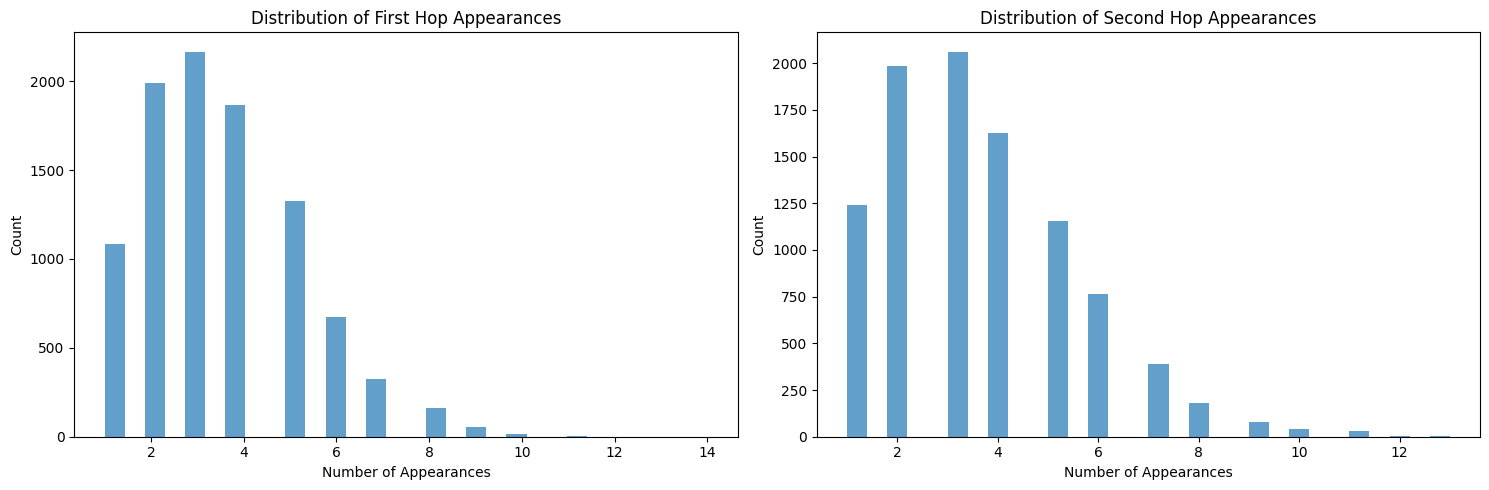

Number of unique first hop profiles: 9672
Number of unique second hop profiles: 9564
Average appearances as first hop: 3.52
Average appearances as second hop: 3.55
Max appearances as first hop: 14
Max appearances as second hop: 13


In [1]:
import os
from transformer_reasoning.train.dataset import load_and_prepare_datasets
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import collections
import torch

# Load tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/llama_multihop_tokenizer")
tokenizer.pad_token = tokenizer.eos_token

# Load dataset with 10000 profiles and relation set 17
train_dataset = load_and_prepare_datasets(
    tokenizer,
    N=10000,
    orders=[1,2],
    relations="17",
    hop_ratio=0.1
)

# Get heldout sets
heldout_sets = train_dataset.heldout_sets

# Initialize counters
first_hop_counts = collections.defaultdict(int)
second_hop_counts = collections.defaultdict(int)

# Count occurrences in complete_two_hop_questions
for profile_idx, relation, subject in heldout_sets['complete_two_hop_questions']:
    first_hop_counts[profile_idx] += 1
    
    # Get the related profile index for second hop
    profile = train_dataset.profiles[profile_idx]
    if relation in profile and 'index' in profile[relation]:
        second_profile_idx = profile[relation]['index']
        if second_profile_idx != -1:  # Make sure it's a valid index
            second_hop_counts[second_profile_idx] += 1

# Create histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(list(first_hop_counts.values()), bins=30, alpha=0.7)
plt.title('Distribution of First Hop Appearances')
plt.xlabel('Number of Appearances')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(list(second_hop_counts.values()), bins=30, alpha=0.7)
plt.title('Distribution of Second Hop Appearances')
plt.xlabel('Number of Appearances')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of unique first hop profiles: {len(first_hop_counts)}")
print(f"Number of unique second hop profiles: {len(second_hop_counts)}")
print(f"Average appearances as first hop: {sum(first_hop_counts.values()) / len(first_hop_counts):.2f}")
print(f"Average appearances as second hop: {sum(second_hop_counts.values()) / len(second_hop_counts):.2f}")
print(f"Max appearances as first hop: {max(first_hop_counts.values())}")
print(f"Max appearances as second hop: {max(second_hop_counts.values())}")